# Collecting Data - Webscraping

The data I'm collecting is from Truecar.com (an online car marketplace) where I'll scrape listings of new and used cars.  To simplify the project, instead of modeling multiple car models I'm only going to model the Acura TLX.  The Acura TLX is rated as the best car to lease in 2020 for its very low price.  I hope to find out through this project that even on the best rated car to lease, it is still cheaper to buy the car new and resell it X-years later (X depends on the amount of years in the term of lease).

I chose to use BeautifulSoup for webscraping because it is much faster then Selenium and has a very low learning curve compared to Scrapy.  Truecar's website is not rendered by Javascript making BeautifulSoup a perfect choice.

While webscraping I'm using a header and a random rest time before making requests to Truecar's website in order to be as respectful as possible to their interface and make my scraping *\"as human as possible\"*.

In [10]:
import os
import pandas as pd
import numpy as np
from re import sub

from bs4 import BeautifulSoup
from requests import get

from time import sleep 

In [11]:
headers = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})

## Used cars

The following code scrapes all used Acura TLX car listings in the United States currently on Truecar's website (in the second line of code you can adjust the number in range(1, X) where X-1 is how many pages of car listings there are):

In [12]:
years = []
makes = []
models = []
engines = []
drives = []
trims = []
prices = []
mileages = []
exteriors = []
interiors = []
locations = []
accidents = []

In [13]:
n_pages = 0

for page in range(1, 71):
    n_pages += 1
    
    truecar_url = 'https://www.truecar.com/used-cars-for-sale/listings/acura/tlx/location-federal-way-wa/?' + 'page=' + str(page) + '&searchRadius=5000'
    r = get(truecar_url, headers=headers)
    page_html = BeautifulSoup(r.text, 'html.parser')
    car_containers = page_html.find_all('div', class_='margin-top-3 col-md-6 col-xl-4')
    
    if car_containers != []:
        
        for container in car_containers:
            
            # year
            if container.find_all('span')[0].text == 'Sponsored':
                year = int(container.find_all('span')[1].text)
            else:
                year = int(container.find_all('span')[0].text)                
            years.append(year)
            
            # make
            if container.find_all('span')[0].text == 'Sponsored':
                make = container.find_all('span')[2].text.split()[0]
            else:
                make = container.find_all('span')[1].text.split()[0]
            makes.append(make)
            
            # model
            if container.find_all('span')[0].text == 'Sponsored':
                model = container.find_all('span')[2].text.split()[1]
            else:
                model = container.find_all('span')[1].text.split()[1]
            models.append(model)
            
            # engine drive trim
            if len(container.find_all('div', class_='font-size-1 text-truncate')[0].text.split()) == 1:
                drive = container.find_all('div', class_='font-size-1 text-truncate')[0].text.split()[0]
                engine = 'I4'
            elif container.find_all('div', class_='font-size-1 text-truncate')[0].text.split()[1] == 'with':
                drive = 'FWD'
                engine = 'I4'
            else:
                drive = container.find_all('div', class_='font-size-1 text-truncate')[0].text.split()[1]
                engine = container.find_all('div', class_='font-size-1 text-truncate')[0].text.split()[0]

            engines.append(engine)
            
            drives.append(drive)
            
            trim = container.find_all('div', class_='font-size-1 text-truncate')[0].text
            trims.append(trim)
            
            # price
            try:
                price = container.find_all('h4', class_='heading-3 margin-y-1 font-weight-bold')[-1].text
                price = int(sub(r'[^\d.]', '', price))
            except:
                price = np.nan
            prices.append(price)
            
            # mileage
            mileage = container.find_all('div', class_='font-size-1 text-truncate')[-1].text.split()[0]
            mileage = int(sub(r'[^\d.]', '', mileage))
            mileages.append(mileage)
            
            # exterior and interior color
            exterior = container.find_all('div', 
                          class_='vehicle-card-location font-size-1 margin-top-1 text-truncate')[0].text.split()[0]
            exteriors.append(exterior)
            
            interior = container.find_all('div', 
                          class_='vehicle-card-location font-size-1 margin-top-1 text-truncate')[0].text.split()[2]
            interiors.append(interior)
            
            # Location
            location = container.find_all('div', class_='vehicle-card-location font-size-1 margin-top-1')[0].text.split('-')[-1].strip()
            locations.append(location)
            # accidents
            
            accident = container.find_all('div', class_='vehicle-card-location font-size-1 margin-top-1')[1].text.split()[0]
            if accident == 'No': 
                accident = 0
            else:
                accident = int(accident)
           
            accidents.append(accident)
            
    else:
        break
            
    sleep(np.random.randint(1,2))

print('You scraped {} pages containing {} properties.'.format(n_pages, len(models)))

You scraped 70 pages containing 2103 properties.


From above we scraped 70 pages of car listings containing 2103 instances of used Acura TLXs.  However, some of this data needs cleaned up.  For example, the car engine is sometimes listed as 3.5L or V6 when they mean the same thing.  If a car has a 3.5L engine it is 6-cylinder.  Likewise for 2.4L and Inline-4. I'm going to do the following for the engine attribute:
* '3.5L' or 'V6' will become '3.5L V6'
* '2.4L' or 'I4' will become '2.4L Inline-4'

In [14]:
cols = ['Year', 'Make', 'Model', 'Mileage', 'Price', 'Drive', 'Engine',
        'Trim', 'Exterior_color', 'Interior_color', 'Location', 'Accidents']

used_cars = pd.DataFrame({'Year': years,
                    'Make': makes,
                    'Model': models,
                    'Mileage': mileages,
                    'Price': prices,
                    'Drive': drives,
                    'Engine': engines,
                    'Trim': trims,
                    'Exterior_color': exteriors,
                    'Interior_color': interiors,
                    'Location': locations, 
                    'Accidents': accidents})[cols]

In [15]:
used_cars.replace('3.5L', 'V6', inplace=True)
used_cars.replace('2.4L', 'I4', inplace=True)

In [16]:
used_cars.replace('V6', '3.5L V-6', inplace=True)
used_cars.replace('I4', '2.4L Inline-4', inplace=True)

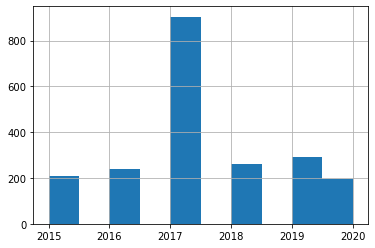

In [17]:
used_cars['Year'].hist()

Finally we save the dataset to a csv file:

In [18]:
PROJECT_ROOT_DIR = "."
CARS_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(CARS_PATH, exist_ok=True)

used_cars.to_csv(CARS_PATH + "/used_cars.csv", index=False)

## New cars

Since the html layout of the pages are different for new cars than used cars we have to use different code to scrape them.  Some differences include:
* No mileage (since they're new they have mileage 0).
* No accidents.
* No exterior or interior colors (so we will have Null values for these columns).

Also, I'm not going to scrape every new car listing.  Most new cars will have similar price and I want my dataset to have a good balance between cars of each year which should help the modeling phase.  

In [19]:
years = []
makes = []
models = []
engines = []
drives = []
trims = []
prices = []
mileages = []
exteriors = []
interiors = []
locations = []
accidents = []

In [20]:
n_pages = 0

for page in range(1, 11):
    n_pages += 1
    
    truecar_url = 'https://www.truecar.com/new-cars-for-sale/listings/acura/tlx/location-federal-way-wa/?' + 'page=' + str(page) + '&searchRadius=5000'
    r = get(truecar_url, headers=headers)
    page_html = BeautifulSoup(r.text, 'html.parser')
    car_containers = page_html.find_all('div', class_='margin-top-3 col-md-6 col-xl-4')
    
    if car_containers != []:
        
        for container in car_containers:
            
            # year make model
            year = container.find_all('span')[0].text
            years.append(year)
            
            make = container.find_all('span')[1].text.split()[0]
            makes.append(make)
            
            model = container.find_all('span')[1].text.split()[1]
            models.append(model)
            
            # engine drive trim
#             if len(container.find_all('div', class_='font-size-1 text-truncate')[0].text.split()) == 1:
#                 drive = container.find_all('div', class_='font-size-1 text-truncate')[0].text.split()[0]
#                 engine = 'I4'
#             elif container.find_all('div', class_='font-size-1 text-truncate')[0].text.split()[1] == 'with':
#                 drive = 'FWD'
#                 engine = 'I4'
#             else:
            try:
                drive = container.find_all('div', class_='font-size-1 text-truncate')[0].text.split()[1]
                engine = container.find_all('div', class_='font-size-1 text-truncate')[0].text.split()[0]
                trim = container.find_all('div', class_='font-size-1 text-truncate')[0].text
            except:
                drive = np.nan
                engine = np.nan
                trim = np.nan
                
            drives.append(drive)
            engines.append(engine)
            trims.append(trim)
            
            # price 
            try:
                price = container.find_all('h4', class_='heading-3 text-muted font-weight-bold')[0].text
                price = int(sub(r'[^\d.]', '', price))
            except:
                price = np.nan
            prices.append(price)
            
            # mileage
            mileage = 0
            mileages.append(mileage)
            
            # exterior and interior color
            exterior = np.nan
            exteriors.append(exterior)
            
            interior = np.nan
            interiors.append(interior)
            
            # location
            
            location = container.find_all('div', class_='vehicle-card-location font-size-1')[0].text.split('-')[-1].strip()
            locations.append(location)
            
            # accidents
            
            accident = 0
            accidents.append(accident)
            
    else:
        break
            
    sleep(np.random.randint(1,2))

print('You scraped {} pages containing {} properties.'.format(n_pages, len(models)))

You scraped 10 pages containing 300 properties.


We successfully scraped 52 pages containing 1540 instances of new Acura TLX listings on Truecar.com.  Now all we have to do is turn our data into a dataframe and make the same adjustments to the engine column as we did above for used cars.  

In [21]:
cols = ['Year', 'Make', 'Model', 'Mileage', 'Price', 'Drive', 'Engine',
        'Trim', 'Exterior_color', 'Interior_color', 'Location', 'Accidents']

new_cars = pd.DataFrame({'Year': years,
                    'Make': makes,
                    'Model': models,
                    'Mileage': mileages,
                    'Price': prices,
                    'Drive': drives,
                    'Engine': engines,
                    'Trim': trims,
                    'Exterior_color': exteriors,
                    'Interior_color': interiors,
                    'Location': locations, 
                    'Accidents': accidents})[cols]

In [22]:
new_cars.replace('3.5L', 'V6', inplace=True)
new_cars.replace('2.4L', 'I4', inplace=True)

In [23]:
new_cars.replace('V6', '3.5L V-6', inplace=True)
new_cars.replace('I4', '2.4L Inline-4', inplace=True)

In [24]:
new_cars.to_csv(CARS_PATH + "/new_cars.csv", index=False)

## Combine new and used cars

I'm saving each dataset seperately and then combined so I have more flexiblity in future projects if I only want to work on used cars or new cars.  Here we combine both datasets using `pd.concat` and create a copy of the dataframe with all rows shuffled to prevent any sampling bias later on in the machine learning phase of the project.  This concludes data collection and we can save the final dataset as a csv file.

In [25]:
cars = pd.concat([used_cars, new_cars])
cars = cars.sample(frac=1)
cars.head()

,Year,Make,Model,Mileage,Price,Drive,Engine,Trim,Exterior_color,Interior_color,Location,Accidents
685,2019,Acura,TLX,5215,38799.0,SH-AWD,3.5L V-6,3.5L SH-AWD with Advance Package,Black,Unknown,"Tustin, CA",0
1871,2018,Acura,TLX,52438,21000.0,FWD,2.4L Inline-4,2.4L FWD with Technology Package,Red,Black,"Ellicott City, MD",0
1861,2016,Acura,TLX,29581,17799.0,FWD,2.4L Inline-4,FWD,Blue,Unknown,"Tinley Park, IL",0
1185,2017,Acura,TLX,25399,26679.0,SH-AWD,3.5L V-6,V6 SH-AWD with Advance Package,Black,Black,"Cockeysville, MD",0
1420,2017,Acura,TLX,31930,19981.0,FWD,3.5L V-6,V6 FWD,White,Black,"Chantilly, VA",0


In [26]:
cars.tail()

,Year,Make,Model,Mileage,Price,Drive,Engine,Trim,Exterior_color,Interior_color,Location,Accidents
2019,2018,Acura,TLX,27058,25313.0,FWD,3.5L V-6,3.5L FWD with Technology Package,Silver,Gray,"Tampa, FL",0
1055,2017,Acura,TLX,20328,17426.0,FWD,2.4L Inline-4,I4 FWD,Black,Black,"Libertyville, IL",0
166,2019,Acura,TLX,0,37695.0,FWD,2.4L Inline-4,2.4L FWD with Technology Package,NaN,NaN,"Riverside, CA",0
256,2020,Acura,TLX,0,37695.0,FWD,2.4L Inline-4,2.4L FWD with Technology Package,NaN,NaN,"Houston, TX",0
978,2018,Acura,TLX,10397,22995.0,FWD,2.4L Inline-4,2.4L FWD,Silver,Gray,"Sugar Land, TX",0


In [27]:
cars.to_csv(CARS_PATH + "/cars.csv", index=False)